# Ensemble Learning and Random Forests <a class="anchor" id="top"></a>

This notebook was written by following the textbook of  Aurélien Géron's *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, along with associated datasets ([Link to Github Repo](https://github.com/ageron/handson-ml/)). The contents in this notebook are my notes from reading the textbook.

### Notebook by Justin Bandoro

Ensemble learning methods are analogous to asking a question to thousands of experts instead of only a single one, who might have bias or poor knowledge. Similarly, if you aggregate predictions of many classifiers or regressors, you will often get better predictions than with the best individual predictor. 

A group of predictors is called an **ensemble**, and technique called **Ensemble Learning**. An example is to train an ensemble of Decision Tree classifiers on a different random subset of the training set. Predictions are made from all individual classifiers, the predicted class is the one that gets the most votes. The ensemble of Decision Trees is known as a **Random Forest**, and is one of the most powerful algorithms.

Ensemble methods are usually used at the end of a project, to combine good predictors into a better predictor. Some of th ensemble methods we'll discuss are: *bagging*, *boosting*, and *stacking*.

1. [Voting Classifiers](#voting)
2. [Bagging and Pasting](#bagging)
3. [Random Forests](#randomforests)
4. [Boosting](#boosting)
5. [Stacking](#stacking)
6. [Exercises](#exercises)

In [46]:
# Load modules
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display, Image 
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import pydotplus
plt.style.use('seaborn-whitegrid')

## 1. Voting Classifiers <a class="anchor" id="voting"></a>
[[back to top]](#top)

If you have tried different classifiers on a problem, maybe a Logistic Regression, SVM, K-Nearest Neighbors, and Decision Tree, and each individually achieved around 80% accuracy. Majority or **hard voting** classifier is if we aggregate the predictions and the class that gets the most votes is the ensemble prediction. Commonly, this voting classifier gets higher accuracy than the best classifier in the ensemble. If each classifier is a *weak learner* (does slightly better than random guessing), the ensemble can be a *strong learner* achieving high accuracy - if there are sufficient number of weak learners.

An example is coin tossing, if there is a biased coin that has a 51% chance of getting heads, and if we repeat flipping 1,000 times you are likely to get 510 heads and 490 tails. Due to the *law of large numbers* if you keep tossing the biased coin, the ratio of heads gets closer to the probability of heads.

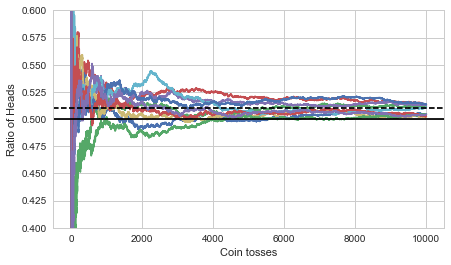

In [17]:
# Example with coing flipping
p_heads = 0.51
coin_tosses = (np.random.rand(10000, 10) < p_heads).astype(np.int32) #10 ensembles of 10,000 coin flips
cum_heads = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

# Plot cumulative coin flipping ratios
fig,ax=plt.subplots(1,figsize=[7,4])
ax.plot(np.arange(1,10001),cum_heads)
ax.set_ylim([0.4,0.6])
ax.axhline(0.51,c='k',ls='--'),ax.axhline(0.50,c='k',ls='-')
ax.set_xlabel('Coin tosses');ax.set_ylabel('Ratio of Heads')

Can see above that after thousands of tosses, the heads ratio of the 10 series approaches the 51% probability. Analogously, if we had 1,000 classifiers that are each have an accuracy of 51%, and you predict the majority you can achieve up to 75% accuracy. 

This is true if all the classifiers are independent and whose errors are uncorrelated, which cannot be the case since they are trained on the same data.

> Ensemble methods are most successful when the predictors are independent of eachother. One way is to use very different algorithms to get different classifiers, increasing the chance that the errors are uncorrelated and improving the accuracy.

Let's build a hard voting classifier using `sklearn`:

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Load moon data
X,y = make_moons(500,noise=0.3,random_state=42)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.25,random_state=42)

# Classifiers -- add scaling for svm and lr
lr_clf = Pipeline([('scale',StandardScaler()),('lr',LogisticRegression(random_state=42) )   ] ) 
rf_clf = RandomForestClassifier(random_state=42)
svm_clf= Pipeline([('scale',StandardScaler()),('svm',SVC(random_state=42,probability=True) )])

vote_clf = VotingClassifier( estimators= [('lr',clone(lr_clf)),
                                          ('rf',clone(rf_clf)),
                                          ('svm',clone(svm_clf))], voting='hard')

# Look at accuracy from all classifiers and voting
for name,clf in zip(['LR','RF','SVM','VOTE'],[lr_clf,rf_clf,svm_clf,vote_clf]):
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xtest)
    score = accuracy_score(ytest,ypred)
    print('{} score: {}'.format(name,score))


LR score: 0.864
RF score: 0.872
SVM score: 0.872
VOTE score: 0.88


Above we see that the voting classifier is just as good and slightly better than the SVM.

**Soft voting** can be used if classifiers can estimate class probability (they have a `predict_proba()` method). The voting predicts the class based on the highest class probability averaged over all the individual classifiers. Soft voting commonly achieves higher accuracy than hard voting since there is more weight to higher confident votes. We can do that below:

In [39]:
# Change to soft voting
vote_clf.set_params(voting='soft')
vote_clf.fit(Xtrain,ytrain)
ypred  = vote_clf.predict(Xtest)
vscore = accuracy_score(ytest,ypred)
print('VOTE score: {}'.format(vscore))

VOTE score: 0.912


We see that soft voting help bump up the accuracy performance of the voting classifier.

## 2. Bagging and Pasting <a class="anchor" id="bagging"></a>
[[back to top]](#top)

The previous approach was to use a different set of classifiers, another is to use the same training algorithm for every predictor but to train on different subsets of the training set. **Bagging** is sampling with replacement, short for bootstrap aggregating, while **Pasting** is sampling without replacement. Bagging and pasting allow training instances to be sampled several times over multiple predictors, but the difference is that bagging allows training instances to be sampled several times for the same predictor. 

When all the predictors are trained, the ensemble can make a prediction for a new instance by aggregating the predictions of all predictors. The aggregation is usually the most frequent like hard voting for classification, or the average for regression. The individual predictors have a higher bias than if they were trained on the full training set, but the aggregation reduces both the bias and variance. The final result is that the ensemble has similar bias but lower variance than if the individual estimator was trained on the full training set.

An advantage is that the predictors can be trained in parallel on different CPU cores, and predictions can be made in parallel. 

### Use in `sklearn`

Both bagging and pasting can be done with the `BaggingClassifier` or `BaggingRegressor`. Pasting is done by setting `bootstrap=False` and the `n_jobs` parameter indicates the number of CPU cores to use.

> The `BaggingClassifier` performs soft voting by default if the base estimator can predict class probability.

In the example below we will use bagging of Decision Tree classifiers on the same moon dataset:

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging classifier with Decision Tree with 500 predictors and 100 samples
base_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(base_estimator=base_clf,n_estimators=500,max_samples=100,
                           bootstrap=True, n_jobs=-1)
bag_clf.fit(Xtrain,ytrain)

# Comapre to base estimator
base_clf.fit(Xtrain,ytrain)

# Predictions
ypred  = vote_clf.predict(Xtest)
bscore = accuracy_score(ytest,ypred)
print('Bagging Decision Trees score: {}'.format(bscore))
ypred  = base_clf.predict(Xtest)
dscore = accuracy_score(ytest,ypred)
print('Single Decision Tree score: {}'.format(dscore))

Bagging Decision Trees score: 0.912
Single Decision Tree score: 0.872


We see above that the bagging improves the accuracy of a single decision tree by 4 percent, now let's look at what the decision boundaries look like for the test data:

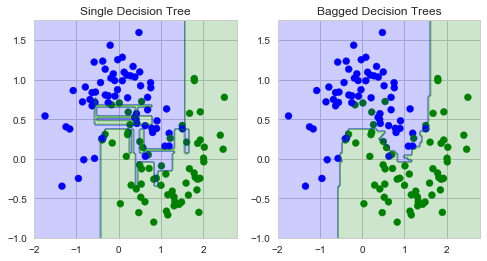

In [51]:
# Function to plot boundaries
def plot_boundaries(clf,x1lim,x2lim, ax=None,cmap=None):
    x1s = np.linspace(x1lim[0],x1lim[1],100)
    x2s = np.linspace(x2lim[0],x2lim[1],100)
    x1,x2 = np.meshgrid(x1s,x2s)
    Xnew = np.c_[x1.ravel(),x2.ravel()]
    y_pred = clf.predict(Xnew).reshape(x1.shape)
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[5,4])
    if cmap is None:
        cmap = 'jet'
    ax.contourf(x1,x2,y_pred,cmap=cmap,alpha=0.2)
    
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,4])
cmap= ListedColormap(['b','g'])
ax1.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(base_clf,[-2,2.8],[-1,1.75],ax=ax1,cmap=cmap)
ax2.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(bag_clf,[-2,2.8],[-1,1.75],ax=ax2,cmap=cmap)
ax1.set_title('Single Decision Tree');ax2.set_title('Bagged Decision Trees')

The ensemble predictions generalizes better than a Decision Tree on the whole training set, this means it has similar bias but the variance is smaller (i.e. it makes the same number of errors but the decision boundary is less irregular). 

Bootstrapping has more diversity on the subsets sampled by each predictor, so bagging inherently has slightly higher bias than pasting, but the predictors are less correlated so the ensemble's variance is reduced. Bagging generally results in better models than pasting, though with extra computational time you can cross-validate bagging vs pasting and select the best.

### Out-of-Bag Evaluation

In bagging, some instances may be sampled many times for the same predictor, and some instances may not be sampled at all. For each predictor, the algorithm will draw $m$ samples from the training set, where by default $m$ is the size of the training set. However, by default samples are drawn **with replacement**, so the number of unique samples will be less than the total number of samples due to duplicates. The instances that are not sampled for a predictor are called **out-of-bag (oob)** instances.

Since the base estimator does not know of the oob instances during training, it can be evaluated on the instances, without the need for separate validation set or cross-validation. This can be done over the whole ensemble, averaging out the oob evaluations of each predictor. In `sklearn` you can set `oob_score=True` to retrieve the evaluation after training:

In [54]:
bag_clf = BaggingClassifier(base_estimator=base_clf,n_estimators=500,max_samples=100,
                           bootstrap=True, n_jobs=-1,oob_score=True)
bag_clf.fit(Xtrain,ytrain)
# oob score
print('oob evaluation: ',bag_clf.oob_score_)
ypred = bag_clf.predict(Xtest)
print('score for test set: ',accuracy_score(ytest,ypred))

oob evaluation:  0.922666666667
score for test set:  0.928


We can see that the oob evaluation is darn near close to the accuracy score on the test set. We can also retrieve the decision function for the training instance by the `oob_decision_function_` variable. Since the base estimator was a Decision Tree, and has a `predict_proba()` method, the decision function is the class probabilities for the training instances.  If `n_estimators` is small it might be possible that a data point was never left out during the bootstrap. In this case, `oob_decision_function_` might will contain `NaN`.

In [59]:
decision_function = bag_clf.oob_decision_function_
decision_function[0:10]

array([[ 0.33243243,  0.66756757],
       [ 0.41866667,  0.58133333],
       [ 0.99731903,  0.00268097],
       [ 0.01842105,  0.98157895],
       [ 0.03100775,  0.96899225],
       [ 0.10309278,  0.89690722],
       [ 0.37209302,  0.62790698],
       [ 0.07272727,  0.92727273],
       [ 0.91798942,  0.08201058],
       [ 0.81510417,  0.18489583]])

For the 1st instance in the training set the oob evaluation estimates 66% probability of belonging to class 1 and 33% to class 0. 

### Random Patches and Random Subspaces

We can also choose to limit the features sampled as well when using a bagging classifier. These are controlled by `max_features` and `bootstrap_features`, and are similar to `max_samples` and `bootstrap` but for the features instead of sampling instances. If used, each predictor will be trained on a random subset of input features. Doing this is useful when working with high-dimensionality inputs like images, and randomly sampling both training instances and features is called **Random Patches method**. 

However, keeping all the training instances, `bootstrap=False` and `max_samples=1.0` and then sampling the features: `max_features < 1.0` and `bootstrap_features=True` is called **Random Subspaces method**. Sampling the feature space results in more predictor diversity and trades a higher bias for lower variance.


## 3. Random Forests <a class="anchor" id="randomforests"></a>
[[back to top]](#top)

A Random Forest is an ensemble of Decision Trees trained with bagging, with typically the `max_samples` set to the size of the training set. Using the `RandomForestClassifier` saves the time of building a `BaggingClassifier` with the base estimator of `DecisionTreeClassifier`. Similarly, for regression `RandomForestRegressor` can be used. 

Let's use the same half moon dataset we've been working on but now train a Random Forest with 500 estimators, and limit for each decision tree to have `max_leaf_nodes=16`. 

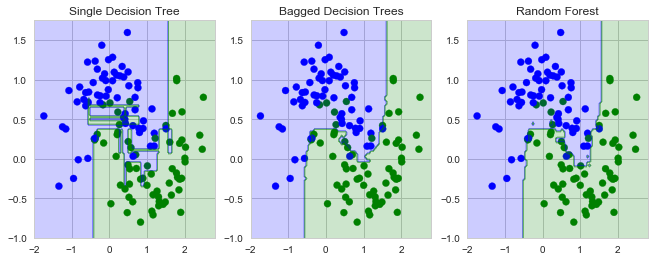

In [60]:
from sklearn.ensemble import RandomForestClassifier 

# Random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rf_clf.fit(Xtrain,ytrain)

# Plot comparison with single tree, bagged tree, and random forest
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=[11,4])
cmap= ListedColormap(['b','g'])
ax1.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(base_clf,[-2,2.8],[-1,1.75],ax=ax1,cmap=cmap)
ax2.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(bag_clf,[-2,2.8],[-1,1.75],ax=ax2,cmap=cmap)
ax3.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(rf_clf,[-2,2.8],[-1,1.75],ax=ax3,cmap=cmap)
ax1.set_title('Single Decision Tree');ax2.set_title('Bagged Decision Trees')
ax3.set_title('Random Forest')

We can see that the Random Forest is similar to the Bagged Decision Tree classifier, as it should be. The difference is that Random Forest forces `max_samples=1.0` for the ensemble and introduces more randomness when growing the trees. Instead of searching for the best feature $k$ when splitting a node, it searches for the best feature within a random subset of features. The result is greater tree diversity, trading a bit higher bias for lower variance. The following `BaggingClassifier` is as close to a Random Forest possible:

`BaggingClassifer( DecisionTreeClassifier(splitter='random',max_leaf_nodes=16),
 n_estimators=500, max_samples=1.0,bootstrap=True)`
 
 ### Extra-Trees Classifier
 
This ensemble method is similar to Random Forest, but when growing a tree: not only are a random subset of features considered for splitting, but more randomness is added so that random thresholds, $t_k$  for each feature are used rather than searching for the best threshold (like Decision Trees do). The resulting forest, has extremely random trees and is called **Extremely Randomized Trees** ensemble, or Extra-Trees for short. Again this trades higher bias for a lower variance.

Extra-Trees are also faster to train than Random Forests since you do not have to find the best threshold value at every node, which is one of highest computationally expensive tasks when growing a tree.

The `ExtraTreesClassifier` has identical parameters to `RandomForestClassifier` but the algorithm differs as described above. Let's quickly see if there is a difference between the two in our example:

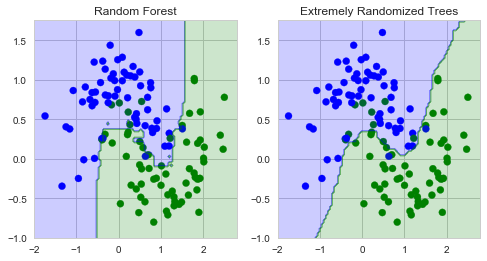

In [61]:
from sklearn.ensemble import ExtraTreesClassifier 

# Random forest classifier
et_clf = ExtraTreesClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
et_clf.fit(Xtrain,ytrain)

# Plot comparison with random forest
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,4])
ax1.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(rf_clf,[-2,2.8],[-1,1.75],ax=ax1,cmap=cmap)
ax2.scatter(Xtest[:,0],Xtest[:,1],c=ytest, cmap=cmap)
plot_boundaries(et_clf,[-2,2.8],[-1,1.75],ax=ax2,cmap=cmap)
ax1.set_title('Random Forest');ax2.set_title('Extremely Randomized Trees')

Above we see that Extra-Trees looks to generalize a bit better to the eye.

> Whether to use Random Forests or Extra-Trees is difficult to know for a problem, and generally you should try both and compare through cross-validation (and hyperparameter tuning).

### Feature Importance

As we saw when looking at Decision Trees, the most important features are likely to appear closest to the root node, while unimportant features are closer to the leaves (or not used at all in growing the tree). Thus from the depth at which features are selected in a tree, we can get an estimate of the feature's importance by calculating the average depth at which it appears over all trees in a forest. This it output automatically after training the `RandomForestClassifier`, in `feature_importances_` variable.

Let's look at an example with the iris data:

In [64]:
from sklearn import datasets

# Load iris dataset
iris = datasets.load_iris()
X = iris['data']  #
y = iris['target'] 

feat_names=iris.feature_names

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
clf.fit(X,y)

# Examine feature importance
df = pd.DataFrame(clf.feature_importances_,index=feat_names,columns=['feat_imp'])
df.sort_values(by='feat_imp',ascending=False)

,feat_imp
petal length (cm),0.448628
petal width (cm),0.419399
sepal length (cm),0.105282
sepal width (cm),0.026691


We see that pedal length and width were found to be the most important in the Random Forest training when compared to the sepal length and width.

Below we perform another example using the MNIST dataset:

In [67]:
from sklearn.datasets import fetch_mldata

# Load MNIST dataset and target labels
mnist = fetch_mldata('MNIST original')
X,y = mnist['data'],mnist['target']

# MNIST data is already split into training and test sets
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Should shuffle the training data
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index], y_train[shuffle_index]

# For this exmaple we'll take a subset of training so it's not too computationally expensive
subset=0.1 # 6000 samples
Nsubs = int( subset*len(y_train) )
X_train_sub = X_train[:Nsubs]; y_train_sub=y_train[:Nsubs]

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf_clf.fit(X_train_sub,y_train_sub)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Time to visualize the feature importance, we'll need to plot the digit space to do this:

[<matplotlib.text.Text at 0x15a0958d0>, <matplotlib.text.Text at 0x15a098320>]

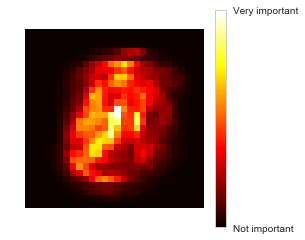

In [72]:
def plot_digit(data,ax=None,cmap=matplotlib.cm.binary):
    if ax is None:
        fig,ax = plt.subplots(1,figsize=[4,4])
    image = data.reshape(28, 28)
    cax= ax.imshow(image, cmap = cmap,
               interpolation="nearest")
    ax.axis("off")
    return fig,ax,cax

feat_imp = rf_clf.feature_importances_
fig,ax,cax = plot_digit(feat_imp,cmap='hot')
cbar=fig.colorbar(cax, ticks=[0,np.max(feat_imp.ravel())])
cbar.ax.set_yticklabels(['Not important','Very important']) 

Above we can see the importance of each pixel for the digit images. Random Forests are useful for a quick understanding of the important features, and can use it for feature selection.


## 4. Boosting <a class="anchor" id="boosting"></a>
[[back to top]](#top)

Boosting, which is an ensemble method also known as *hypothesis boosting*, combines many weak learners to form a strong learner. The weak learners are trained **sequentially**, each trying to improve on the predecessor. Of all the boosting algorithms, the most popular ones are AdaBoost and Gradient Boosting.

### AdaBoost

One method for a sequential predictor to improve on it's predecessor is to focus on the training instances that the predecessor underfitted. Can think of it as the new predictor focusing more on the hard to classify/regress cases. This is called Adaptive Boosting (AdaBoost for short).

The first base estimator is trained, and then it makes predictions on the training set. The weight of the misclassified instances are increased. A second classifier is trained using the updated weights and then makes predictions on the training set, weights are again updated and so forth. 

Let's look at an example using a SVM classifier, where we can manually specify weights when fitting the model. Higher weights force the classifier to put more emphasis on those points. 

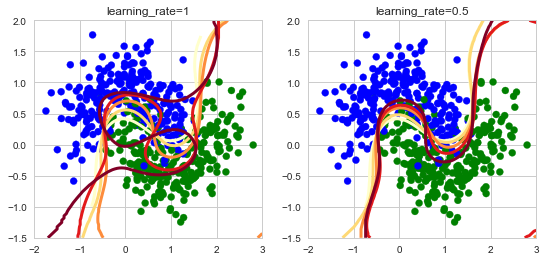

In [94]:
# Load moon data
X,y = make_moons(500,noise=0.3,random_state=42)

# Function to draw decision boundary at probability of 50% line
def draw_boundary_line(clf,x1lim,x2lim,ax=None,color='k'):
    if ax is None: fig,ax = plt.subplots(1,figsize=[5,4])
    x1s = np.linspace(x1lim[0],x1lim[1],100)
    x2s = np.linspace(x2lim[0],x2lim[1],100)
    x1,x2 = np.meshgrid(x1s,x2s)
    Xnew = np.c_[x1.ravel(),x2.ravel()]
    y_proba = clf.predict_proba(Xnew)[:,0].reshape(x1.shape) #only need 1 class
    ax.contour(x1,x2,y_proba,levels=[0.5], colors=[color],linewidths=[3.0])

def svm_boost_classifier(X,y,learning_rate=0,n_iter=5,ax=None ):
    clf = Pipeline( [('scale',StandardScaler() ),  
                     ('svm', SVC(kernel='rbf',probability=True,random_state=10) )
                    ])
    # Initial training
    clf.fit(X,y)
    ypred=clf.predict(X)
    if ax is not None: #plot 
        # Colors for iterations
        cm_subsection = np.linspace(0.0, 1.0, n_iter) 
        colors = [ cm.YlOrRd(x) for x in cm_subsection ]
        draw_boundary_line(clf,[-1.5,2.5],[-1,1.75],ax=ax,color=colors[0])
    weights = np.ones(len(X))
    for n in range(n_iter-1):
        weights[y!=ypred] = weights[y!=ypred]*(1+learning_rate)
        clf.fit(X,y,svm__sample_weight = weights)
        y_pred = clf.predict(X)
        if ax is not None:
            draw_boundary_line(clf,[-2,3],[-1.5,2],ax=ax,color=colors[n+1])
        
fig,(axes)=plt.subplots(1,2,figsize=[9,4])
cmap= ListedColormap(['b','g'])
for ax,learning_rate in zip(axes.ravel(),[1,0.5]):
    ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
    svm_boost_classifier(X,y,learning_rate,5,ax=ax)
    ax.set_title('learning_rate={}'.format(learning_rate))

Above the decision boundaries go from light to dark for sequential boundaries in the SVM classifier. The weights of the incorrect instances are boosted in each iteration. The plot on the right is the same but with a learning rate that is halved - which means the misclassified instances' weights are half as much. We can see that the smaller learning rate is better, as the larger one misses the optimal solution. There are similarities to Gradient Descent, where instead of tweaking a single predictor's parameters to minimize a cost function, AdaBoost adds predictors to the ensemble gradually making it better.

When all the predictors are trained, the ensemble makes predictions like bagging but the predictors have different weights depending on their overall accuracy on the weighted training set.

> The main drawback to AdaBoost is the sequential learning technique which cannot be parallelized, since you can only train each predictor after the previous one has been evaluated.

#### AdaBoost Algorithm

Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. The first predictor is trained and its weighted error rate, $r_1$, is computed on the training set:

$r_j =  \frac{  \sum\limits_{i=1, \hat{y_j}^{(i)}\ne y^{(i)} }^{m} w^{(i)} }  { \sum\limits_{i=1}^{m} w^{(i)} }$, where

* $\hat{y_j}^{(i)}$ is the $j$<sup>th</sup> predictor's prediction for the $i$<sup>th</sup> instance

The predictor's weight, $\alpha_j$, which is used for the ensemble prediction, is equal to:

$\alpha_j =  \eta \log \frac{1-r_j}{r_j} $.

* where $\eta$ is the learning rate hyperparameter (default is 1).

The more accurate the predictor is, the larger it's $\alpha_j$ will be, and if it it worse than random guessing, its weight will be negative. The instance weights are updated, with the  misclassified instances being boosted:

for $i=1,2,\dots, m$

if $\hat{y_j}^{(i)} = y^{(i)}$, $w^{(i)} = w^{(i)}$,

if $\hat{y_j}^{(i)} \ne y^{(i)}$, $w^{(i)} = w^{(i)}\exp(\alpha_j)$.

All of the instance weights are then normalized, they  are divided by $\sum\limits_{i=1}^{m} w^{(i)} $. Then a new predictor is trained using the updated weights, and the whole method is repeated until the algorithm stops when the desired number of estimators/predictors is reached or if a perfect predictor is found.

To make the ensemble prediction, AdaBoost computes the predictions of all the predictors and weighs them using the predictor weights. The predicted class is one that has the majority of the weighted votes:

$\hat{y}(\textbf{x}) = \mathrm{argmax}_k \sum\limits_{\substack{j=1 \\ \hat{y_j}(\textbf{x})=k} }^{N} \alpha_j$, where $N$ is the number of predictors.

`sklearn` uses a multiclass version of AdaBoost called *Stagewise Additive Modeling using a Multiclass Exponential loss function* (SAMME). With only 2 classes, SAMME is equivalent to AdaBoost. If the predictors inherently can estimate the class probabilities (`predict_proba()` method), SAMME.R can be used, which relies on class probabilities rather than predictions and generally performs better.

The example below trains an `AdaBoostClassifier` on Decision Tree classifiers with a depth of only 1, called *Decision Stumps* a tree with a single node and 2 leaf nodes. This is also the default base estimator for AdaBoost:

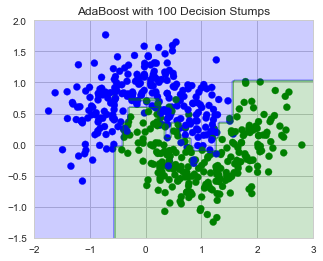

In [111]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost on moon data
ada_clf = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1),n_estimators=100, 
                             algorithm='SAMME.R',learning_rate=0.5)
ada_clf.fit(X,y)

# Plot boundaries
fig,ax = plt.subplots(1,figsize=[5,4])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)
plot_boundaries(ada_clf,[-2,3],[-1.5,2],ax=ax,cmap=cmap)
ax.set_title('AdaBoost with 100 Decision Stumps')

> If AdaBoost is overfitting the training set, you can reduce the number of estimators or regularize the base estimator!


### Gradient Boosting

Gradient Boosting is similar to AdaBoost where predictors in an ensemble are trained sequentially with each correcting on the predecessor. Instead of modifying the instance weights at each iteration, it tries to fit a new predictor to the residual errors made by the previous predictor.

Below we show an example using the base estimator for regression being a Decision Tree on noisy quadratic data, the ensemble prediction is the sum of the first tree and then predictors trained on the subsequent residuals:

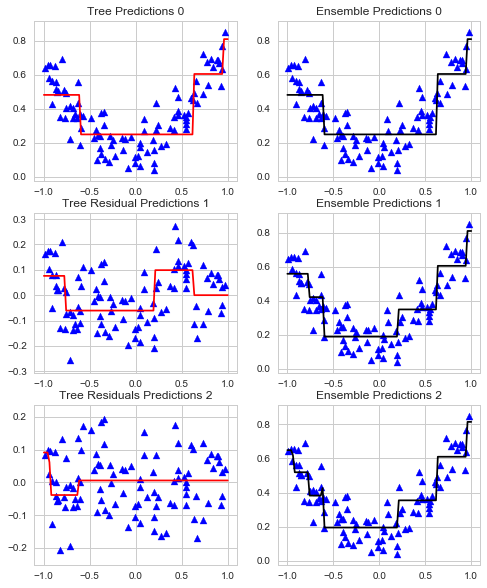

In [115]:
from sklearn.tree import DecisionTreeRegressor

# Generate quadratic data
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()
x0 = np.linspace(-1,1,100).reshape(-1,1)

# Decision Tree Regressor 0
tree_reg0 = DecisionTreeRegressor(max_depth=2)
tree_reg0.fit(X,y)
errors0 = y - tree_reg0.predict(X)

# Decision Tree Regressor 1
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,errors0)
errors1 = errors0 - tree_reg1.predict(X)

# Decision Tree Regressor 2
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,errors1)

# Plot predictions and residuals and ensemble predictions
fig,(axes) = plt.subplots(3,2,figsize=[8,10])
# 0 - residuals
axes[0,0].scatter(X[:,0],y,color='b',marker='^') 
pred0 = tree_reg0.predict(x0)
axes[0,0].plot(x0,pred0,color='r');axes[0,0].set_title('Tree Predictions 0')
# 0 - ensemble
axes[0,1].scatter(X[:,0],y,color='b',marker='^') 
axes[0,1].plot(x0,pred0,color='k');axes[0,1].set_title('Ensemble Predictions 0')
# 1 - residuals
axes[1,0].scatter(X[:,0],errors0,color='b',marker='^') 
pred1 = tree_reg1.predict(x0)
axes[1,0].plot(x0,pred1,color='r') ;axes[1,0].set_title('Tree Residual Predictions 1')
# 1 - ensemble
axes[1,1].scatter(X[:,0],y,color='b',marker='^') 
axes[1,1].plot(x0,pred0+pred1,color='k') ;axes[1,1].set_title('Ensemble Predictions 1')
# 2 - residuals
axes[2,0].scatter(X[:,0],errors1,color='b',marker='^') 
pred2 = tree_reg2.predict(x0)
axes[2,0].plot(x0,pred2,color='r');axes[2,0].set_title('Tree Residuals Predictions 2')
# 2 - ensemble
axes[2,1].scatter(X[:,0],y,color='b',marker='^') 
axes[2,1].plot(x0,pred0+pred1+pred2,color='k');axes[2,1].set_title('Ensemble Predictions 2')   

We see above that as we add predictions from the predictors made on the residuals, the ensemble prediction gets better. 

`sklearn` has an easier way to perform Gradient Boosting with Decision Trees, in the class `GradientBoostingRegressor`, where the hyperparameters that control the ensemble training, like `n_estimators` can be specified along with those to control the growing of the Decision Tree predictors (`max_depth`, `min_samples_leaf`, etc). 

The repeat the analysis above but with the easier to use regressor:

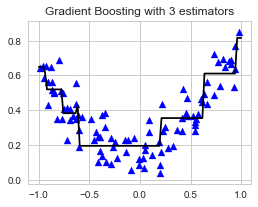

In [118]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(n_estimators=3, learning_rate=1.0, max_depth=2)
gb_reg.fit(X,y)

# Plot GB predictions
fig,ax = plt.subplots(1,figsize=[4,3])
ax.scatter(X[:,0],y,color='b',marker='^') 
ax.plot(x0,gb_reg.predict(x0),'k');ax.set_title('Gradient Boosting with 3 estimators')

We see we get the same results as when we did it manually with calculating the residuals. The `learning_rate` hyperparameter scales the contributions of each subsequent tree, if it's a low value such as 0.1 then more trees in the ensemble will be needed, but the predictions generalize better. This regularization is known as *shrinkage*. 

We show below comparison of a low learning rate with a high number of estimators and a small number of estimators:

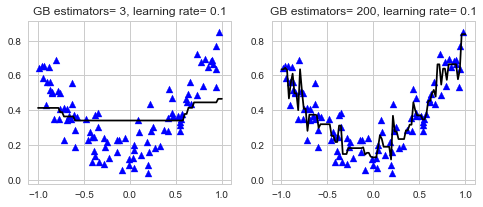

In [119]:
gb_regL = GradientBoostingRegressor(n_estimators=3, learning_rate=0.1, max_depth=2)
gb_regH = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=2)
gb_regL.fit(X,y);gb_regH.fit(X,y)

# Plot GB predictions
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,3])
[ax.scatter(X[:,0],y,color='b',marker='^') for ax in [ax1,ax2] ]
ax1.plot(x0,gb_regL.predict(x0),'k'); ax1.set_title('GB estimators= 3, learning rate= 0.1')
ax2.plot(x0,gb_regH.predict(x0),'k'); ax2.set_title('GB estimators= 200, learning rate= 0.1')

We see the two extremes above, on the left there are not enough estimators to fit the training set but on the right there are too many and we are overfitting the training set. But how do we know the right number of estimators to use for Gradient Boosting? We can use early stopping, where if the validation score does not improve after adding more predictors then we can stop. One way to do this, is to use the method `staged_predict()` which returns an iterator over the prediction made by the ensemble at each stage of training.

We will look at the validation curve with respect to the number of predictors:

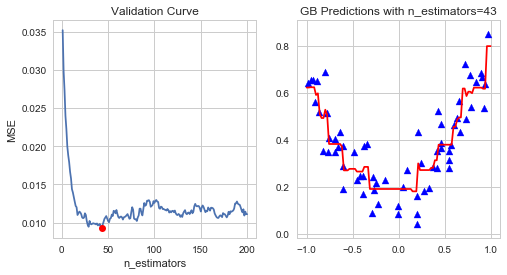

In [156]:
from sklearn.metrics import mean_squared_error

# Split into training and validation set
Xtrain,Xval,ytrain,yval = train_test_split(X,y,test_size=0.33)

# Train Graident Booster
gb_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=2)
gb_reg.fit(Xtrain,ytrain)

# Staged predictions on validation set
y_staged = gb_reg.staged_predict(Xval)
staged_errors = [mean_squared_error(yval,ypred) for ypred in y_staged]

# Best estimator
best_estimator = np.argmin(staged_errors)
gb_regbest = GradientBoostingRegressor(n_estimators=best_estimator+1,learning_rate=0.1,max_depth=2)
gb_regbest.fit(Xtrain,ytrain)

# Plotting
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,4])
ax1.plot(np.arange(1,201),staged_errors)
ax1.plot(np.arange(1,201)[best_estimator],staged_errors[best_estimator],'ro')
ax2.scatter(Xtrain[:,0],ytrain,color='b',marker='^')
preds = gb_regbest.predict(x0)
ax2.plot(x0,preds,'r')
ax1.set_title('Validation Curve');ax1.set_xlabel('n_estimators');ax1.set_ylabel('MSE')
ax2.set_title('GB Predictions with n_estimators={}'.format(best_estimator+1))

Can see above that the optimal number of estimators is below 50. Though the problem with our method above is that we had to train 200 estimators when the best one was well less than 200, so wasted computational time. We can implement early stopping by setting `warm_start=True`, which makes `GradientBoostingRegressor` keep existing trees/estimators each time the `.fit()` method is called, allowing incremental training:

In [153]:
# Call GB with warm start
gb_reg= GradientBoostingRegressor(warm_start=True,max_depth=2)

# Implement training with early stopping
minimum_val_error = float("inf")
for n_estimators in range(1,201):
    gb_reg.n_estimators = n_estimators
    gb_reg.fit(Xtrain,ytrain) # continues where left off
    yval_pred = gb_reg.predict(Xval)
    val_error  = mean_squared_error(yval_pred,yval)
    if val_error < minimum_val_error:
        minimum_val_error= val_error
        error_inc = 0 
        best_model = clone(gb_reg)
    else: # if error starts to increase and does so for 5 more estimators
        error_inc+=1
        if error_inc == 5:
            n_estimator_best = n_estimators-5
            break # stop early
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=37, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=True)

We see above that it also stopped at 37 trees. The `GradientBoostinRegressor` also supports a hyperparameter called `subsample` which specifies the fraction of training instances to subsample when building each tree. This is known as *Stochastic Gradient Boosting* and speeds up the training. By doing so though, we trade a bit higher bias for lower variance. 

> Other loss functions can be used for Gradient Boosting, and is controlled by the hyperparameter `loss`.


## 5. Stacking <a class="anchor" id="stacking"></a>
[[back to top]](#top)




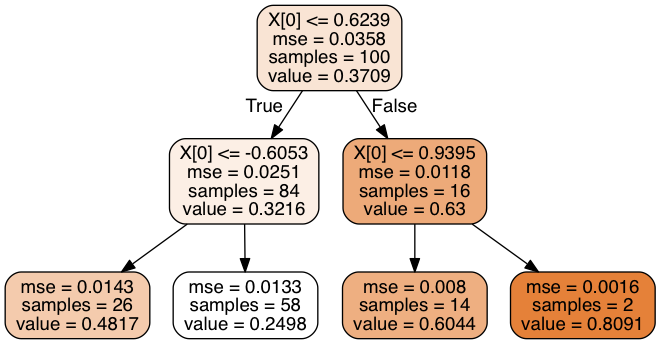

In [33]:
# Visualize
dot_data= export_graphviz(reg,out_file=None,rounded=True,filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

Suppose we wanted to make a prediction for a new instance with $x=0.75$. The root node we branch out to the right (False) since it is greater than 0.62. In the next depth 1 node, the instance takes the left (True) branch since it is less than 0.94. The assigned value is then 0.60 for the prediction. This prediction is the average value of the 14 training instances in the leaf node. The visualization above also gives the MSE of prediction for the leaf node.

For regression, the prediction for each region is always the average target value of the instances that fall in that region. We can see the effect of changing the `max_depth` below:


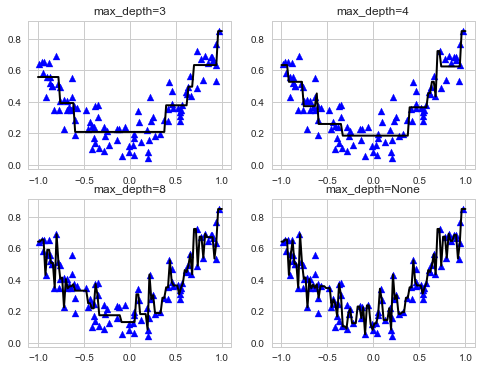

In [34]:
# Hyperparameters
max_depths       = [3,4,8,None] # max number of depths

# Set up plots
fig,axes = plt.subplots(2,2,figsize=[8,6])
axes = axes.ravel()

# Loop through parameters for training
i=0
for max_depth in max_depths:
    reg.set_params(max_depth=max_depth).fit(X,y)
    ax=axes[i]; ax.scatter(X[:,0],y,color='b',marker='^')
    ypred = reg.predict(x0)
    ax.plot(x0,ypred,c='k',lw=2.0)
    ax.set_title('max_depth={}'.format(max_depth))
    i+=1

Even a `max_depth` of 8 we can see there is overfitting, and if we do not constrain the depths at all the decision tree regressor is greatly overfitting the training data. We can repeat the above with no `max_depth` restrictions but regularize via the `min_samples_leaf`:

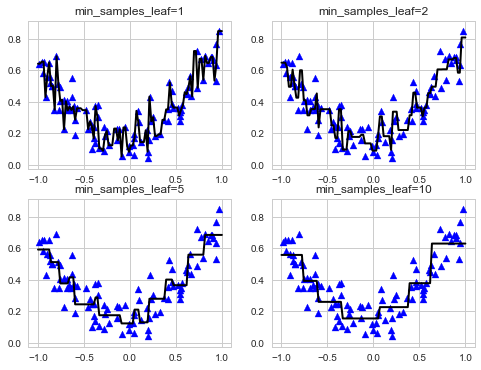

In [37]:
# Hyperparameters
min_samples_leafs = [1,2,5,10]

# Set up plots
fig,axes = plt.subplots(2,2,figsize=[8,6])
axes = axes.ravel()

# Loop through parameters for training
i=0
for min_samples_leaf in min_samples_leafs:
    reg.set_params(max_depth=None,min_samples_leaf=min_samples_leaf).fit(X,y)
    ax=axes[i]; ax.scatter(X[:,0],y,color='b',marker='^')
    ypred = reg.predict(x0)
    ax.plot(x0,ypred,c='k',lw=2.0)
    ax.set_title('min_samples_leaf={}'.format(min_samples_leaf))
    i+=1

Just like classification if we increase the `min_samples_leaf` we regularize the model. 

The CART algorithm is similar to what we had for classification, but the cost function has the MSE instead of the ratio of classes for the samples. It tries to split the training set into subsets that minimize the MSE for feature $k$ and threshold $t_k$:

$J(k,t_k) = \frac{m_{left}}{m} {MSE}_{left} + \frac{m_{right}}{m} {MSE}_{right} $, where

* ${MSE}_{left/right} = \sum\limits_{i\in node} (\hat{y_{node}} - y^{(i)})^2 $, and
* $\hat{y_{node}} = \frac{1}{m_{node}}\sum\limits_{i\in node} y^{(i)}$

To avoid overfitting, some degree of regularization is commonly needed for Decision Trees. 


## 5. Instability <a class="anchor" id="instability"></a>
[[back to top]](#top)

There are limitation using Decisions Trees for classification and regression. As we saw earlier the boundaries are orthogonal with the splits perpendicular to the feature axes. This makes the boundaries sensitive to training set rotation.

We show an example below for two datasets, one that is a rotation of another:

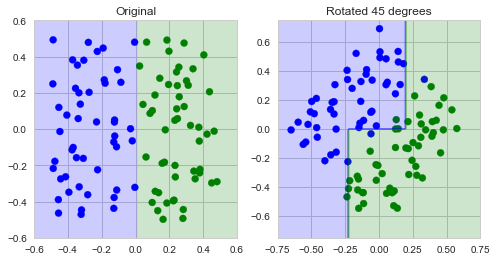

In [22]:
from scipy import ndimage
# Make data
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

# Rotate the data
angle    = 45
theta    = np.pi * angle / 180
rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
Xsrot    = np.dot(Xs,rotation)

# Classify data
clf1 = DecisionTreeClassifier(min_samples_leaf=4)
clf2 = DecisionTreeClassifier(min_samples_leaf=4)
clf1.fit(Xs,ys)
clf2.fit(Xsrot,ys)

# Plot with classifier boundaries
fig,(ax1,ax2) = plt.subplots(1,2,figsize=[8,4])
cmap= ListedColormap(['b','g'])
ax1.scatter(Xs[:,0],Xs[:,1],c=ys, cmap=cmap)
plot_boundaries(clf1,[-0.6,0.6],[-0.6,0.6],ax=ax1,cmap=cmap) 
ax2.scatter(Xsrot[:,0],Xsrot[:,1],c=ys, cmap=cmap)
plot_boundaries(clf2,[-0.75,0.75],[-0.75,0.75],ax=ax2,cmap=cmap) 
ax1.set_title('Original');ax2.set_title('Rotated {} degrees'.format(angle))

The dataset on the right, which has been rotated, the decision boundary is not linear which we would hope for, when dealing with linearly separable data. One way to limit this is to perform principal component analysis (PCA) to prepare the data before training:

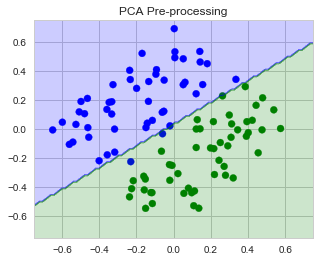

In [26]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components=2)

clf_pipe = Pipeline([('PCA', pca),
                     ('clf', clf2) 
                    ])
clf_pipe.fit(Xsrot,ys)
fig,ax1 = plt.subplots(1,1,figsize=[5,4])
ax1.scatter(Xsrot[:,0],Xsrot[:,1],c=ys, cmap=cmap)
plot_boundaries(clf_pipe,[-0.75,0.75],[-0.75,0.75],ax=ax1,cmap=cmap)
ax1.set_title('PCA Pre-processing')

We can see that PCA pre-processing helps improve the instability of Decision Trees. Another limitation with Decision Trees is that they can be sensitive to data outliers, and the training algorithm is essentially stochastic as `sklearn` selects the set of features randomly to evaluate at each node. This means you may get different decision boundaries and predictions from models on the same training data unless `random_state` hyperparameter is specified.



## 6.  Exercises <a class="anchor" id="exercises"></a>
[[back to top]](#top)

> **1.**  What is the approximate depth of a Decision Tree trained (without restrictions on a training set with 1 million instances?

If we assume that the Decision Tree is well balanced, then this requires roughly  $O(\log_2(m))$ nodes. Which is around a depth of 20. 

> **2.** Is a node's Gini impurity generally lower or greater than its parent's? Is it generally lower/greater, or *always* lower/greater?

The Gini impurity is generally lower in a child node than the parent's as the algorithm seeks to minimize the child node's impurity until it cannot be split anymore. Though since there are 2 children nodes, it is possible that one may be larger than the parent's, but weighted average of the two is smaller than the parent's.

> **3.** If a Decision Tree is overfitting the training set, is it a good idea to try decreasing `max_depth`?

As we found, decreasing the depth of a Decision Tree helps regularize the model. So decreasing the `max_depth` hyperaparameter is one method to prevent overfitting.

> **4.** If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?

Scaling of training data is not necessary for Decision Trees, so doing so would not help with the underfitting. Rather, data rotation through PCA would be a better pre-processing technique. 

> **5.** If it takes one hour to train a Decision Tree on a training set of 1 million instances, roughly how much time will it take to train another Decision Tree on a training set of 10 million instances?

The training algorithm has a computational complexity of order, $O(n\times m\times \log(m))$, so if we assume that between the two cases above the number of features are the same then we can find that time for 10 million instances is equal to:

$ \frac{1h}{10^{6} \log_2{10^6}} 10^{7} \log_2{10^7} = 11.7 h$

The Dual form is faster to solve than the primal when the number of training instances is smaller than the number of features. So for the question above, if speed is priority then the primal form would be faster. But the dual form allows the kernel trick to be applied so the extra computational time might be worth it.

> **6.** If your training set contains 100,000 instances, will setting `presort=True` help speed up training?

No, presorting only helps improve speed for instances less than a few thousand. Above it makes it slower.


> **7.** Train and fine-tune a Decision Tree for the moons dataset:
1. Generate a moons dataset with 10,000 samples and noise of 0.4
2. Split into a training set and test set
3. Use grid search to find good hyperparameters for `DecisionTreeClassifier`
4. Train it on the full training set using these hyperparameters, and then measure the performance on the test set. You should get an accuracy of 85-87%.

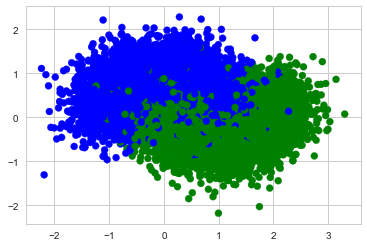

In [43]:
from sklearn.datasets import make_moons

### 7.1 Make moons dataset
X,y = make_moons(10000,noise=0.4)

# Plot data
fig,ax = plt.subplots(1,figsize=[6,4])
cmap= ListedColormap(['b','g'])
ax.scatter(X[:,0],X[:,1],c=y, cmap=cmap)

In [44]:
### 7.2 split into train and test sets
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)

#### 7.3 Use grid search to find opitmal hyperparameters for DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Report for grid search
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  (results['mean_test_score'][candidate]),
                  (results['std_test_score'][candidate])  ))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

tree_clf   = DecisionTreeClassifier()
param_grid = [ {# 'max_depth':[None,10,9,8,7],
                # 'min_samples_leaf':[30,40,50,60],
                 'min_samples_split':[2,3,4],
                 'max_leaf_nodes':[10,20,40]
              }]
# Grid search
GS_tree = GridSearchCV(tree_clf,param_grid,cv=5,scoring='accuracy',n_jobs=-1)
GS_tree.fit(Xtrain,ytrain)

#Print scores
results = GS_tree.cv_results_
report(results)

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.866 (std: 0.010)
Parameters: {'max_leaf_nodes': 20, 'min_samples_split': 4}



`GridSearchCV` automatically trains the best estimator on the whole training set, so it is not needed to do this and we can then look at the accuracy on the test set:

In [45]:
### 7.4 Evaluate on test data
from sklearn.metrics import accuracy_score

ypred = GS_tree.predict(Xtest)
print('Accuracy of test set :',accuracy_score(ytest,ypred))

Accuracy of test set : 0.874


We were able to get an accuracy of around 85% with the noisy moon dataset.

> **8.** Grow a forest of Decision Trees:
1. Continue the previous exercise and generate 1,000 subsets of the training set, each containing 100 instances selected randomly using `ShuffleSplit`
2. Train one Decision Tree on each subset, using the best hyperparameter values found above. Evaluate these 1,000 trees on the test set. Since they are trained on smaller sets, the trees will likely perform worse than the first Decision Tree.
3. Now for each test set instance, generate the predictions of the 1,000 trees, and keep only the most frequent prediction to get a majority-vote.
4. Evaluate these predictions on the test set, and you should obtain a higher accuracy by about 0.5-1.5%.

In [46]:
### 8.1
from sklearn.model_selection import ShuffleSplit

n_trees    = 1000
n_instances= 100

subsets = []
rs = ShuffleSplit(n_splits=n_trees, test_size=len(Xtrain) - n_instances)

for train_index, test_index in rs.split(Xtrain):
    Xsubtrain = Xtrain[train_index]
    ysubtrain = ytrain[train_index]
    subsets.append((Xsubtrain,ysubtrain))

### 8.2 
from sklearn.base import clone

# Create forest of decision trees
forest = [clone(GS_tree.best_estimator_) for _ in range(n_trees)]
scores = []
for tree, (Xsubtrain,ysubtrain) in zip(forest,subsets):
    tree.fit(Xsubtrain,ysubtrain)
    ypred = tree.predict(Xtest)
    scores.append(accuracy_score(ytest,ypred) )

print('Mean of all {} trees on test set: {}'.format(n_trees,np.mean(scores)))
    

Mean of all 1000 trees on test set: 0.79975


In [47]:
### 8.3 
from scipy.stats import mode

ypreds_all = [] 
# Save all the predictions instead of taking mean of resulting scores
for i,tree in enumerate(forest):
    ypred = tree.predict(Xtest)
    ypreds_all.append(ypred)
ypreds_all = np.array(ypreds_all)

# For each test instance, take a majority vote
yvote,counts = mode(ypreds_all,axis=0)

print('Majority vote of all {} trees accuracy score on test set: {}'.format(n_trees,accuracy_score(ytest,yvote.squeeze())))


Majority vote of all 1000 trees accuracy score on test set: 0.8725


We see an increase in the accuracy using the forest of 1,000 trees compared to a single Decision Tree.

## License

The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/).